# CelebA Validsation EfficientNet

In [16]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from sklearn.metrics import mean_squared_error
    
import mydata
import performance
from performance import PerformanceMeasure, PerformanceEstimation
from distance import DistanceMeasure
from skincolors import IndividualTypologyAngle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
db = "UTKFace"
root = f"../../dataset/AAAI 2025/{db}/"
df_valid_ef3 = mydata.load_and_process_csv(f"{root}evaluation/df_valid_ef3.csv", True)
df_valid_resnet = mydata.load_and_process_csv(f"{root}evaluation/df_valid_resnet.csv", True)
df_valid_vgg = mydata.load_and_process_csv(f"{root}evaluation/df_valid_vgg.csv", True)

In [20]:
baseline = df_valid_ef3.sample(n=1, random_state=12)
baseline_filepath = baseline["masked filepath"].values[0]
print(f"File Name: {baseline['filepath'].values[0]}")

img = cv2.imread(baseline_filepath)
baseline_skin_pixels_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ita = IndividualTypologyAngle(baseline_skin_pixels_image)
baseline_mean_ita = ita.get_mean_ita()
print(f"Conventional ITA values: {baseline_mean_ita}")
baseline_nuance_ita = ita.get_nuance_ita()

File Name: ../../dataset/AAAI 2025/UTKFace/data/44_0_3_20170119195216221.jpg.chip.jpg
Conventional ITA values: 17.321600446516427


In [17]:
means = []
distances = []

for _, row in df_valid_ef3.iterrows():

    img = cv2.imread(row["masked filepath"])
    skin_pixels_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if skin_pixels_image is None:
        # print(_)
        means.append(np.nan)
        distances.append(np.nan)
    else:
        ita = IndividualTypologyAngle(skin_pixels_image)
        means.append(ita.get_mean_ita())
        nuance_ita = ita.get_nuance_ita()

        dm = DistanceMeasure(baseline_nuance_ita, nuance_ita)
        distance = dm.sign_wasserstein_distance()
        distances.append(distance)

In [18]:
num_nans = np.sum(np.isnan(distances))
print(f"Number of np.nan values in 'distance': {num_nans}")

Number of np.nan values in 'distance': 0


In [21]:
df_valid_ef3["distance"] = distances
df_valid_resnet["distance"] = distances
df_valid_vgg["distance"] = distances

In [23]:
from performance import PerformanceOptimisation
po_efficientnet = PerformanceOptimisation(df_valid_ef3, db, "Efficientnet")
po_resnet = PerformanceOptimisation(df_valid_resnet, db, "ResNet")
po_vgg = PerformanceOptimisation(df_valid_vgg, db, "VGG")

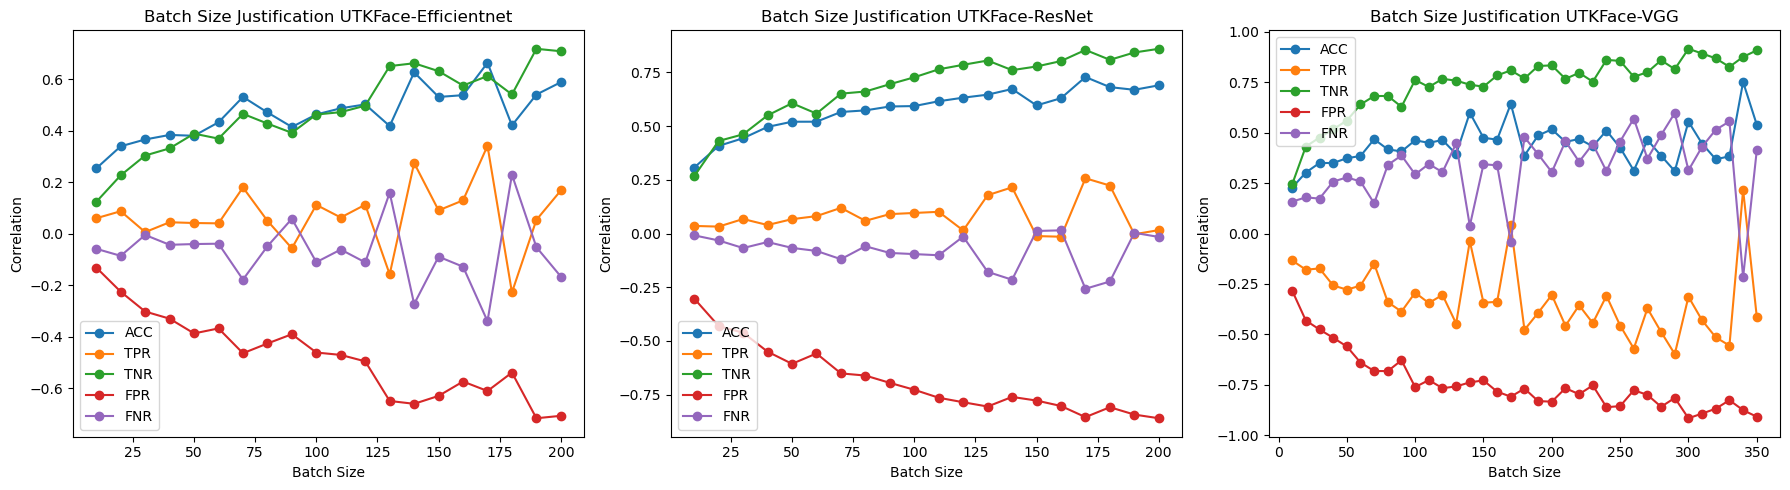

In [24]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning) # To adovid error message related one labels
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    po_efficientnet.check_batch_size(ax[0])
    po_resnet.check_batch_size(ax[1])
    po_vgg.check_batch_size(ax[2], b_start = 10, b_end = 360, b_step = 10)
    plt.tight_layout()
    plt.show()

In [27]:
# Correlation check
po_efficientnet.check_optimal_batch_correlation(batch_size=130)
po_resnet.check_optimal_batch_correlation(batch_size=150)
po_vgg.check_optimal_batch_correlation(batch_size=140)

          distance       ACC       TPR       TNR       FPR       FNR
distance  1.000000  0.417403 -0.158454  0.650183 -0.650183  0.158454
ACC       0.417403  1.000000  0.722890  0.589325 -0.589325 -0.722890
TPR      -0.158454  0.722890  1.000000  0.004072 -0.004072 -1.000000
TNR       0.650183  0.589325  0.004072  1.000000 -1.000000 -0.004072
FPR      -0.650183 -0.589325 -0.004072 -1.000000  1.000000  0.004072
FNR       0.158454 -0.722890 -1.000000 -0.004072  0.004072  1.000000
          distance       ACC       TPR       TNR       FPR       FNR
distance  1.000000  0.596615 -0.011892  0.777915 -0.777915  0.011892
ACC       0.596615  1.000000  0.716945  0.835603 -0.835603 -0.716945
TPR      -0.011892  0.716945  1.000000  0.255566 -0.255566 -1.000000
TNR       0.777915  0.835603  0.255566  1.000000 -1.000000 -0.255566
FPR      -0.777915 -0.835603 -0.255566 -1.000000  1.000000  0.255566
FNR       0.011892 -0.716945 -1.000000 -0.255566  0.255566  1.000000
          distance       ACC      

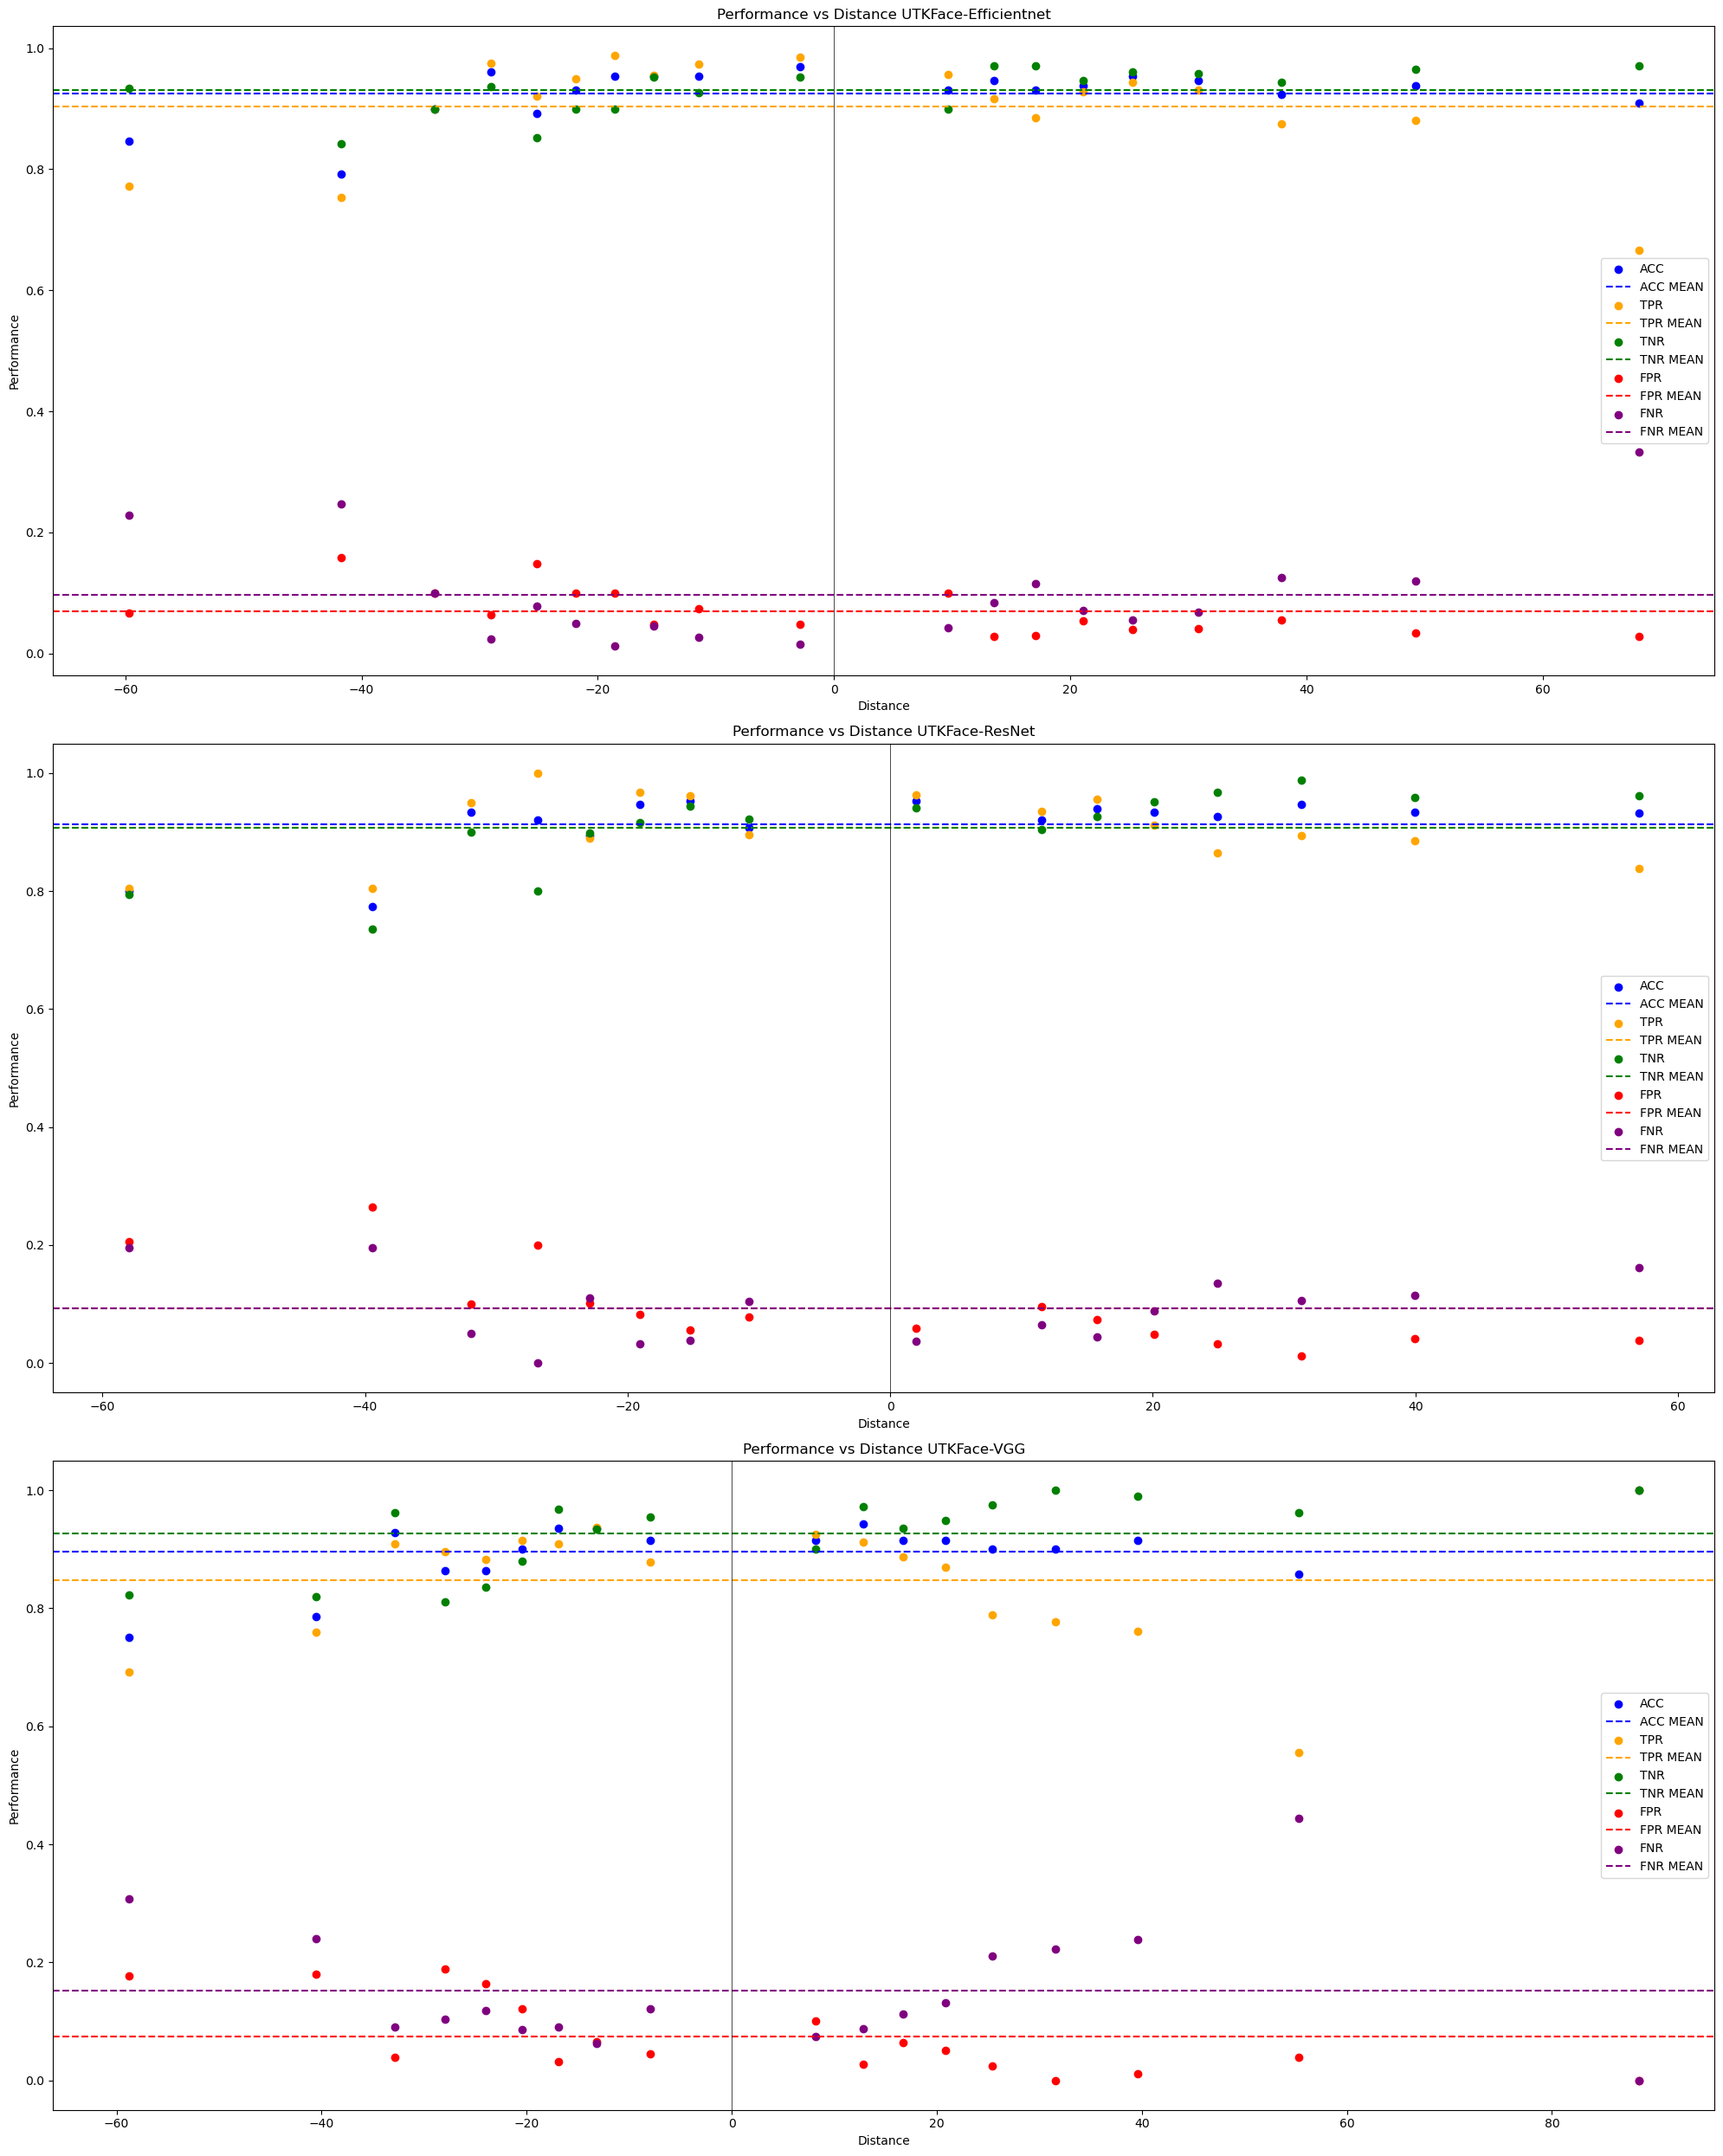

In [28]:
fig, ax = plt.subplots(3, 1, figsize=(20, 25))
po_efficientnet.display_distance_performance(ax[0])
po_resnet.display_distance_performance(ax[1])
po_vgg.display_distance_performance(ax[2])
plt.tight_layout()
plt.show()

UTKFace - Efficientnet
Degree 1: MSE = 0.0008221478698982555
Degree 2: MSE = 0.0008221324019042522
Degree 3: MSE = 0.0007210322250985592
Degree 4: MSE = 0.0005939830939392459
Degree 5: MSE = 0.00054673751372594
UTKFace - ResNet
Degree 1: MSE = 0.0018463953254457214
Degree 2: MSE = 0.0014614966169631178
Degree 3: MSE = 0.0014559359514128242
Degree 4: MSE = 0.0013447405546990585
Degree 5: MSE = 0.0009183286151922131
UTKFace - VGG
Degree 1: MSE = 0.0018099260794387031
Degree 2: MSE = 0.0015722135466036732
Degree 3: MSE = 0.0015721059084240789
Degree 4: MSE = 0.0015457687870264482
Degree 5: MSE = 0.001544658140122242


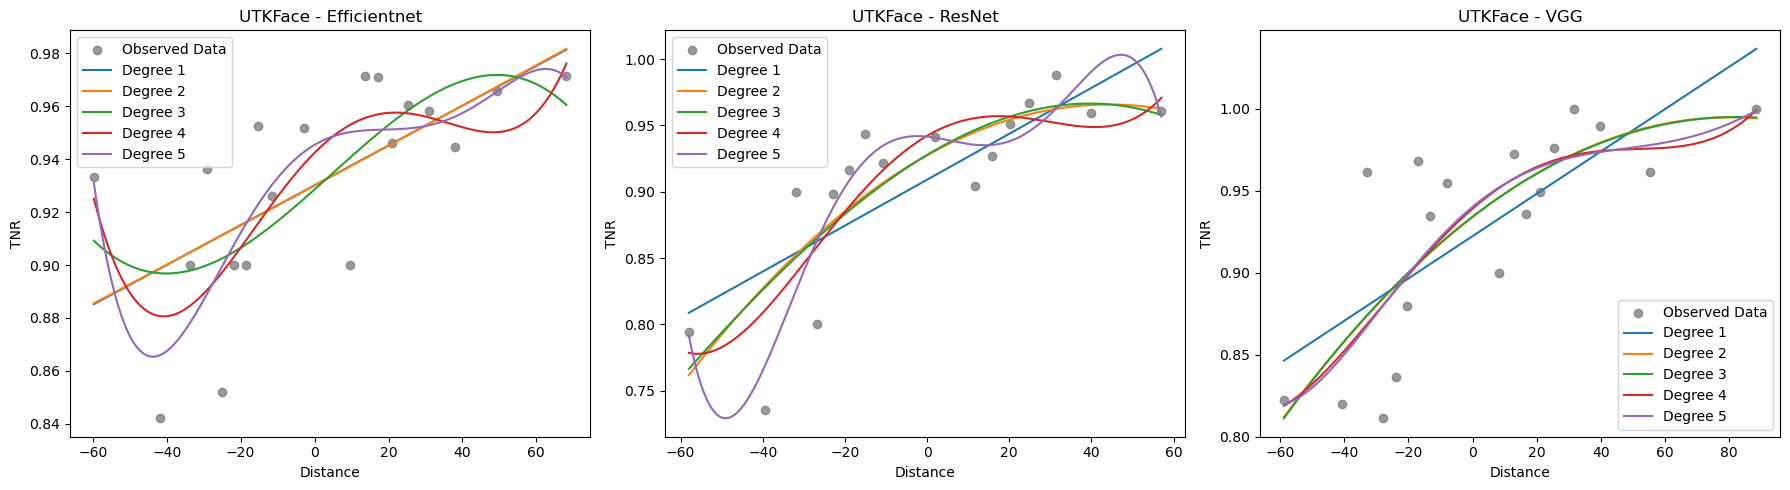

In [30]:
metric = "TNR" # Focus metric for penalty
degrees = [1, 2, 3, 4, 5]

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
po_efficientnet.check_optimised_degree(metric, degrees, ax[0])
po_resnet.check_optimised_degree(metric, degrees, ax[1])
po_vgg.check_optimised_degree(metric, degrees, ax[2])

plt.tight_layout()
plt.show()

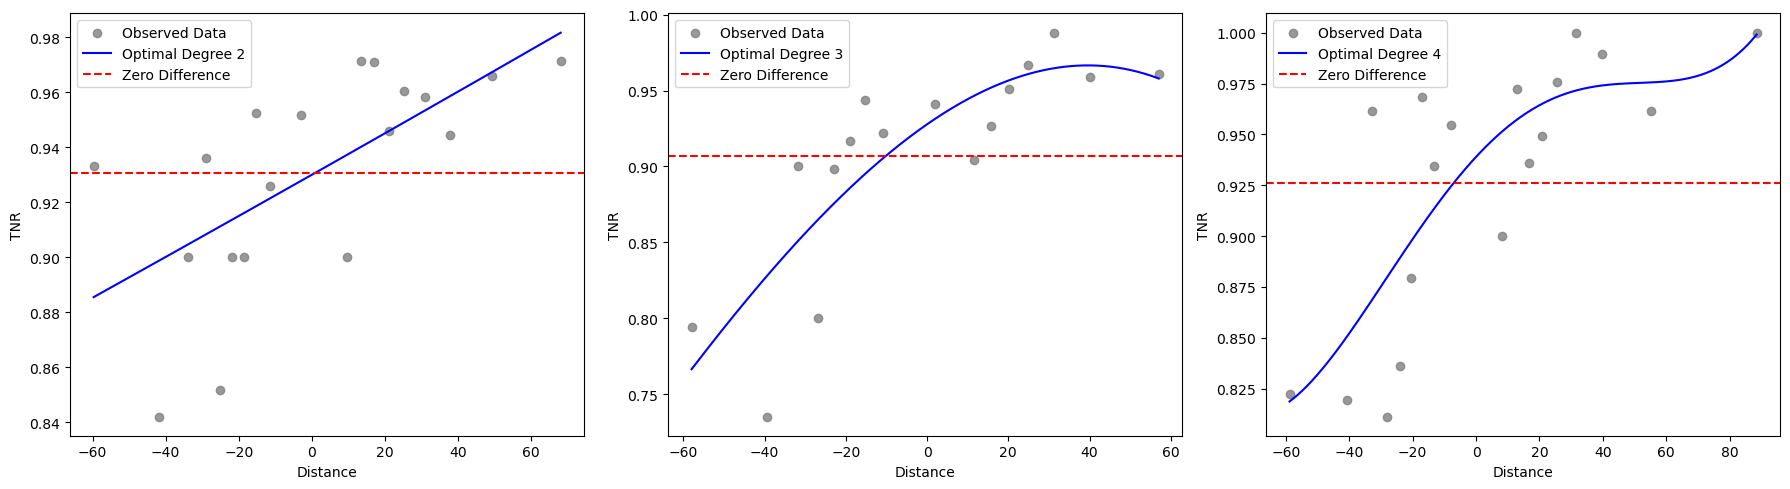

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

optimal_deg = 2
po_efficientnet.diaplay_optimal_degree(metric, optimal_deg, ax[0])

optimal_deg = 3
p = po_resnet.diaplay_optimal_degree(metric, optimal_deg, ax[1])

optimal_deg = 4
po_vgg.diaplay_optimal_degree(metric, optimal_deg, ax[2])

plt.tight_layout()
plt.show()

In [33]:
polynomial_save_file = f"{root}model/pickle/polynomial_model_ef3.pkl"
po_efficientnet.save_optimal_polynomial_model(polynomial_save_file)

polynomial_save_file = f"{root}model/pickle/polynomial_model_resnet.pkl"
po_resnet.save_optimal_polynomial_model(polynomial_save_file)

polynomial_save_file = f"{root}model/pickle/polynomial_model_vgg.pkl"
po_vgg.save_optimal_polynomial_model(polynomial_save_file)

Modle saved
Modle saved
Modle saved
